In [3]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [4]:
from langchain_core.messages import AIMessage, HumanMessage
from pprint import pprint

messages=[AIMessage(content=f"How can I Help You?",name="AI Model")]
messages.append(HumanMessage(content=f"I want to learn Coding", name="Anil"))
messages.append(AIMessage(content=f"Sure, Which Language do you want to learn?",name="AI Model"))
messages.append(HumanMessage(content=f"I want to learn Python",name="Anil"))


for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: AI Model

How can I Help You?
================================ Human Message =================================
Name: Anil

I want to learn Coding
================================== Ai Message ==================================
Name: AI Model

Sure, Which Language do you want to learn?
================================ Human Message =================================
Name: Anil

I want to learn Python


In [5]:
## Chat Models

from langchain_groq import ChatGroq

groq_llm=ChatGroq(model="qwen/qwen3-32b")

result=groq_llm.invoke(messages)

In [6]:
result.response_metadata

{'token_usage': {'completion_tokens': 1272,
  'prompt_tokens': 54,
  'total_tokens': 1326,
  'completion_time': 2.741746365,
  'prompt_time': 0.002259805,
  'queue_time': 0.225029171,
  'total_time': 2.74400617},
 'model_name': 'qwen/qwen3-32b',
 'system_fingerprint': 'fp_5cf921caa2',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None}

## TOOLS

In [32]:
def add(a:int, b:int) -> int:
    """Adds two integers and returns the result."""
    return a+b

In [9]:
## Binding tool with llm

llm_with_tools=groq_llm.bind_tools([add])

tool_call=llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 2 ", name="Anil")])

In [10]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'zbeweyrw3',
  'type': 'tool_call'}]

### Using Messages as state

In [53]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class State(TypedDict):
    messages:list[AnyMessage]

In [54]:
## We should use Reducers to append the messages
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]


In [45]:
initial_messages=[AIMessage(content=f"How can I Help You?",name="AI Model")]
initial_messages.append(HumanMessage(content=f"I want to learn Coding", name="Anil"))
initial_messages

[AIMessage(content='How can I Help You?', additional_kwargs={}, response_metadata={}, name='AI Model'),
 HumanMessage(content='I want to learn Coding', additional_kwargs={}, response_metadata={}, name='Anil')]

In [46]:
ai_message=AIMessage(content=f"Sure, Which Language do you want to learn?",name="AI Model")
ai_message

AIMessage(content='Sure, Which Language do you want to learn?', additional_kwargs={}, response_metadata={}, name='AI Model')

In [55]:
### Reducers add_messagesis to append instead of override
add_messages(initial_messages,ai_message)

[AIMessage(content='How can I Help You?', additional_kwargs={}, response_metadata={}, name='AI Model', id='41734dd8-15f0-4706-80dd-6d0944517445'),
 HumanMessage(content='I want to learn Coding', additional_kwargs={}, response_metadata={}, name='Anil', id='8fb6090f-8d0c-431f-909f-086073827cbf'),
 AIMessage(content='Sure, Which Language do you want to learn?', additional_kwargs={}, response_metadata={}, name='AI Model', id='da6eed93-c204-49ce-ab05-3a5ffbde9afd')]

In [57]:
## chatbot node functionality 

def llm_tools(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

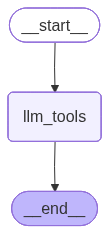

In [58]:
from IPython.display import Image,display
from langgraph.graph import StateGraph, START, END
builder=StateGraph(State)

builder.add_node("llm_tools", llm_tools)

builder.add_edge(START,"llm_tools")
builder.add_edge("llm_tools",END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



In [59]:
## Invocation of the graph

messages=graph.invoke({"messages":"What is 2 plus 2?"})

for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2?
================================== Ai Message ==================================
Tool Calls:
  add (pgm1nf69b)
 Call ID: pgm1nf69b
  Args:
    a: 2
    b: 2


In [60]:
tools=[add]

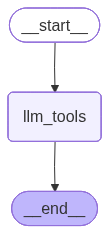

In [61]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

builder=StateGraph(State)

builder.add_node("llm_tools",llm_tools)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"llm_tools")
builder.add_conditional_edges(
                    "llm_tools",
                    # if the latest message (result) from assistant is a tool call -> tools_condition routes to tools
                    # if the latest message (result) from assistant is not a tool call -> tools_condition routes to END
                    tools_condition)

builder.add_edge("tools",END)

graph1=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [63]:
## Invocation of the graph

messages=graph1.invoke({"messages":"What is 2 plus 2?"})

for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2?
================================== Ai Message ==================================
Tool Calls:
  add (bwdm5zaah)
 Call ID: bwdm5zaah
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [64]:

messages=graph1.invoke({"messages":"What is langgraph?"})

for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What is langgraph?
================================== Ai Message ==================================

The term "langgraph" does not appear to be related to the available tools I have access to, which currently only include a basic "add" function for integer arithmetic. If you're asking about a specific library, framework, or concept related to language processing or graph structures, I don't have the capability to provide information beyond the tools listed. Could you clarify your question or check if there's a different way I might assist?
